In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 14

from sklearn import linear_model, model_selection, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, f1_score, brier_score_loss
import xgboost

pd.set_option('display.float_format', lambda x: '%3f' % x)

In [2]:
def plot_cm(classifier,
             X_var,
             y_var,
             pred_var,
             cmap=plt.cm.Blues,
             title='Confusion matrix'):
    
    plot_confusion_matrix(classifier, X_test, y_test, cmap=plt.cm.Blues)  
    plt.show() 
    
    cm = pd.DataFrame(metrics.confusion_matrix(y_true=y_var, y_pred=pred_var))

In [3]:
train = pd.read_csv('../../data/train.csv')
test = pd.read_csv('../../data/test.csv')
validate = pd.read_csv('../../data/validate.csv')

In [4]:
train.drop('Unnamed: 0',axis=1,inplace=True)
test.drop('Unnamed: 0',axis=1,inplace=True)
validate.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
X= train.drop(["target",'eval_set'],axis=1)
y= train['target']

In [6]:
feature_cols = X.columns

In [7]:
X_train, X_test, y_train, y_test = (
    train_test_split(X,y, test_size=0.2, random_state=42))

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2254200, 20)
(563551, 20)
(2254200,)
(563551,)


In [9]:
rfreg = RandomForestClassifier(oob_score=True, random_state=1)
rfreg.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

In [10]:
pd.DataFrame(
    {'feature':feature_cols, 
     'importance':rfreg.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
19,user_product_last_time_product_ordered,0.789072
18,user_product_reorder_rate,0.087866
17,user_product_order_rate,0.038945
3,user_product_count,0.030071
5,user_product_last_order,0.024089
11,user_total_orders,0.006731
4,user_product_first_order,0.003996
8,product_order_twice_ratio,0.003676
13,user_avg_days_between_orders,0.002920
10,user_unique_product_perc,0.001826


In [11]:
X_imputed_df = pd.DataFrame(X_train, columns = feature_cols)

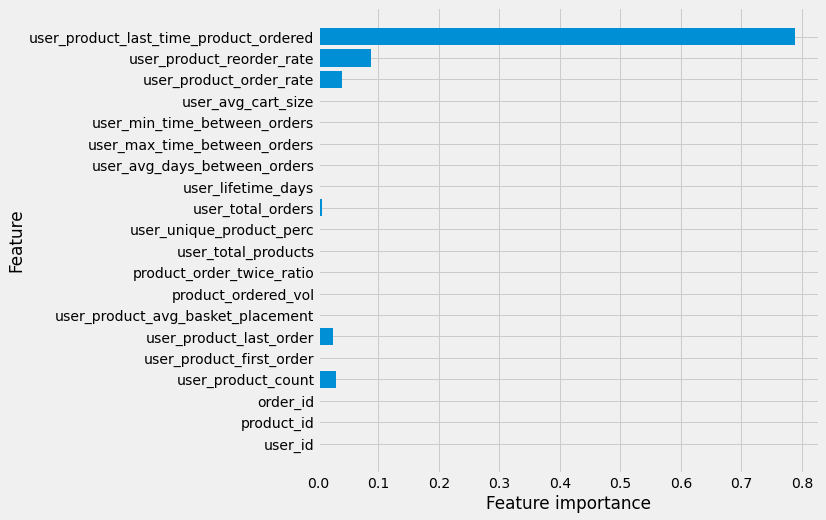

In [12]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_imputed_df.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(rfreg)

In [13]:
print((rfreg.oob_score_))

0.9993518764972052


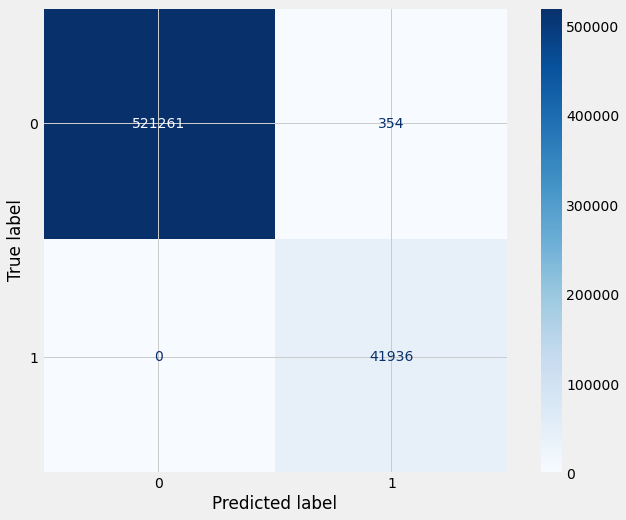

In [14]:
y_pred = rfreg.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_cm(rfreg, X_test, y_test, y_pred)

In [15]:
rfreg.score(X_train, y_train)

1.0

In [16]:
rfreg.score(X_test, y_test)

0.9993718403480786

In [17]:
f1=f1_score(y_test,y_pred)
brier=brier_score_loss(y_test,y_pred)
auc=roc_auc_score(y_test,y_pred)

print(classification_report(y_test,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    521615
           1       0.99      1.00      1.00     41936

    accuracy                           1.00    563551
   macro avg       1.00      1.00      1.00    563551
weighted avg       1.00      1.00      1.00    563551

f1:0.99580,auc:0.99966,loss_score:0.00063


In [18]:
#check against validation set

X_val = validate.drop(["target",'eval_set'],axis=1)
y_val = validate['target']

# rfreg.score(X_val,y_val)
y_pred = rfreg.predict(X_val)

f1=f1_score(y_val,y_pred)
brier=brier_score_loss(y_val,y_pred)
auc=roc_auc_score(y_val,y_pred)

print(classification_report(y_val,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    869657
           1       0.99      1.00      1.00     69593

    accuracy                           1.00    939250
   macro avg       1.00      1.00      1.00    939250
weighted avg       1.00      1.00      1.00    939250

f1:0.99545,auc:0.99963,loss_score:0.00068


## XGBoost

In [28]:
gbm = xgboost.XGBClassifier()
gbm.fit(X_train, y_train)
training_pred = gbm.predict(X_train)
y_pred = gbm.predict(X_test)
training_accuracy = accuracy_score(y_train, training_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(test_accuracy * 100))

Training Accuracy: 99.96%
Validation accuracy: 99.95%


In [29]:
f1=f1_score(y_test,y_pred)
brier=brier_score_loss(y_test,y_pred)
auc=roc_auc_score(y_test,y_pred)

print(classification_report(y_test,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    521615
           1       0.99      1.00      1.00     41936

    accuracy                           1.00    563551
   macro avg       1.00      1.00      1.00    563551
weighted avg       1.00      1.00      1.00    563551

f1:0.99679,auc:0.99972,loss_score:0.00048


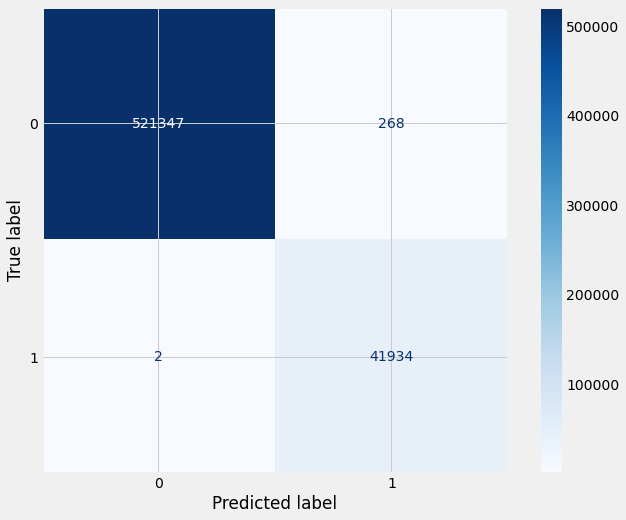

In [30]:
y_pred = gbm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_cm(gbm, X_test, y_test, y_pred)

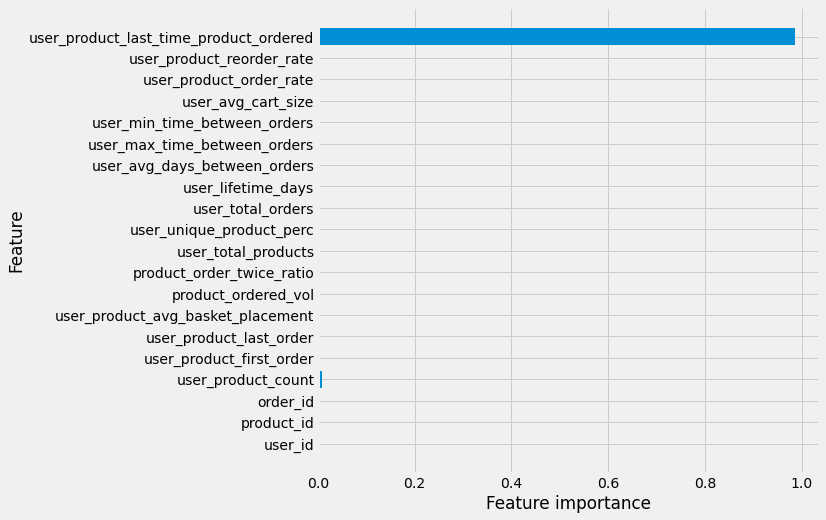

In [31]:
plot_feature_importances(gbm)

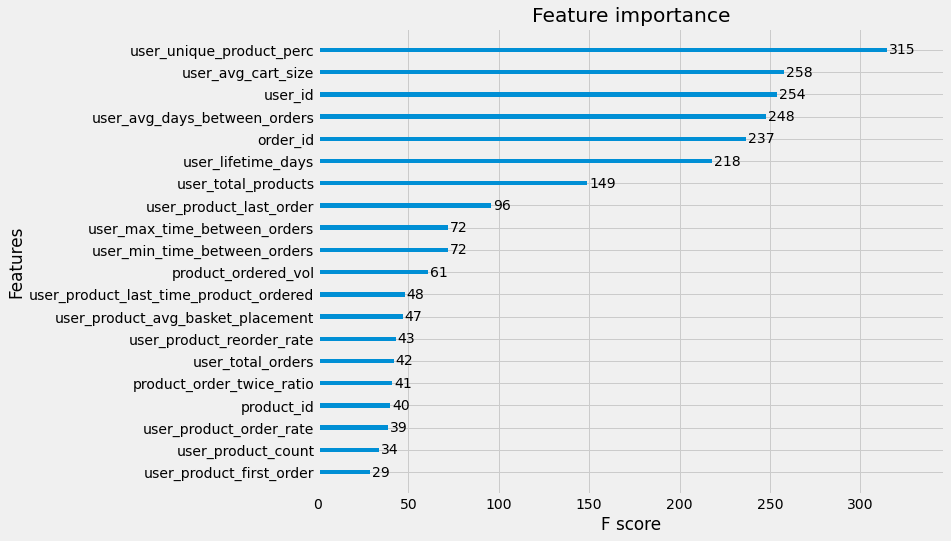

In [32]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(gbm)
pyplot.show()

In [23]:
gbm = xgboost.XGBClassifier(objective='binary:logistic',
                            max_depth=10,
                            learning_rate=.2,
                            n_estimators=140,
                            subsample=.8,
                            colsample_bytree=.8)

gbm.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                eval_metric='auc',
                early_stopping_rounds=2)

training_pred = gbm.predict(X_train)
y_pred = gbm.predict(X_test)
training_accuracy = accuracy_score(y_train, training_pred)
test_accuracy = accuracy_score(y_test, y_pred)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(test_accuracy * 100))

[0]	validation_0-auc:0.97957
Will train until validation_0-auc hasn't improved in 2 rounds.
[1]	validation_0-auc:0.98025
[2]	validation_0-auc:0.99960
[3]	validation_0-auc:0.99964
[4]	validation_0-auc:0.99963
[5]	validation_0-auc:0.99965
[6]	validation_0-auc:0.99968
[7]	validation_0-auc:0.99970
[8]	validation_0-auc:0.99970
[9]	validation_0-auc:0.99969
[10]	validation_0-auc:0.99971
[11]	validation_0-auc:0.99974
[12]	validation_0-auc:0.99976
[13]	validation_0-auc:0.99978
[14]	validation_0-auc:0.99980
[15]	validation_0-auc:0.99979
[16]	validation_0-auc:0.99982
[17]	validation_0-auc:0.99984
[18]	validation_0-auc:0.99986
[19]	validation_0-auc:0.99985
[20]	validation_0-auc:0.99985
Stopping. Best iteration:
[18]	validation_0-auc:0.99986

Training Accuracy: 99.93%
Validation accuracy: 99.93%


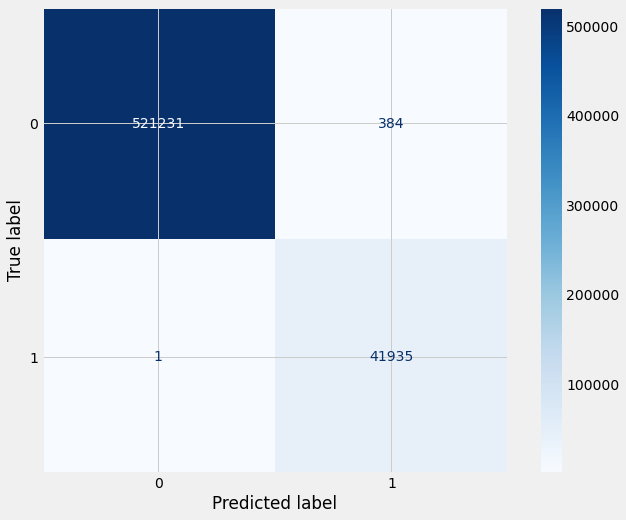

In [24]:
y_pred = gbm.predict(X_test)
cnf_matrix = confusion_matrix(y_test, y_pred)
plot_cm(gbm, X_test, y_test, y_pred)

In [25]:
f1=f1_score(y_test,y_pred)
brier=brier_score_loss(y_test,y_pred)
auc=roc_auc_score(y_test,y_pred)

print(classification_report(y_test,y_pred))
print(f"f1:{f1:.5f},auc:{auc:.5f},loss_score:{brier:.5f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    521615
           1       0.99      1.00      1.00     41936

    accuracy                           1.00    563551
   macro avg       1.00      1.00      1.00    563551
weighted avg       1.00      1.00      1.00    563551

f1:0.99543,auc:0.99962,loss_score:0.00068


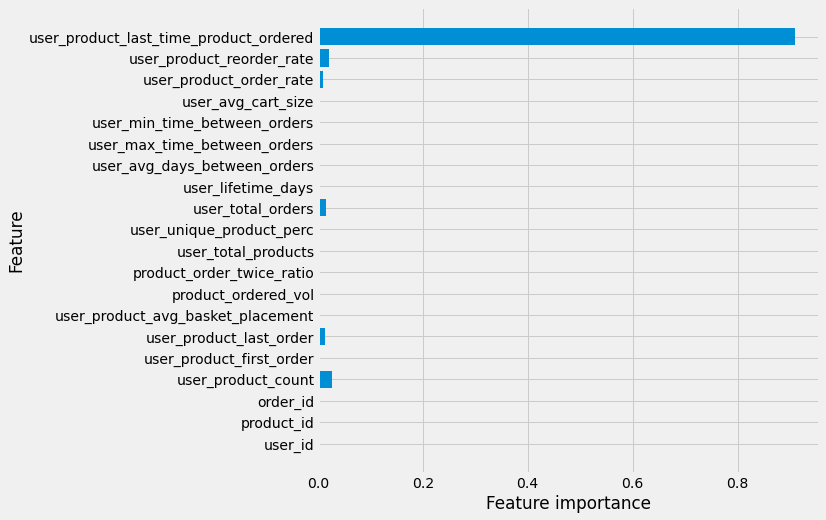

In [26]:
plot_feature_importances(gbm)

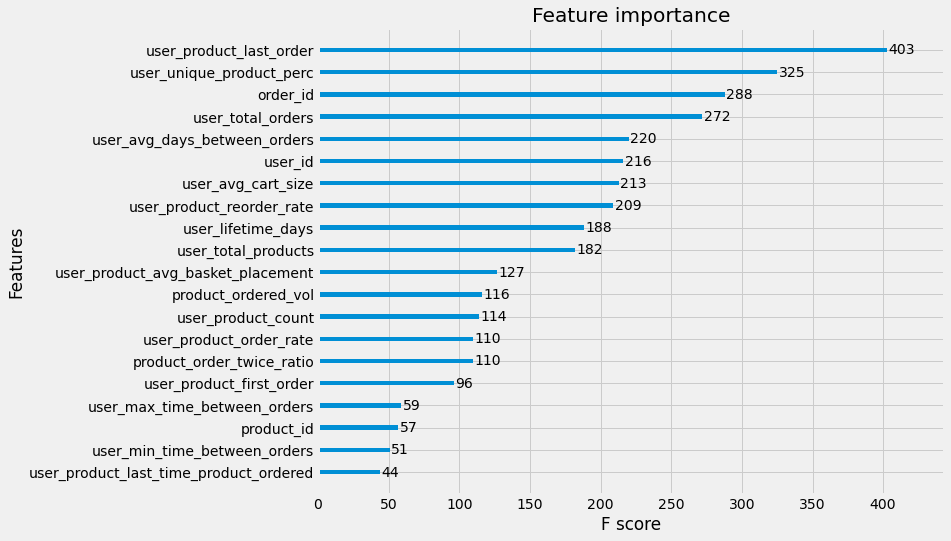

In [27]:
plot_importance(gbm)
pyplot.show()